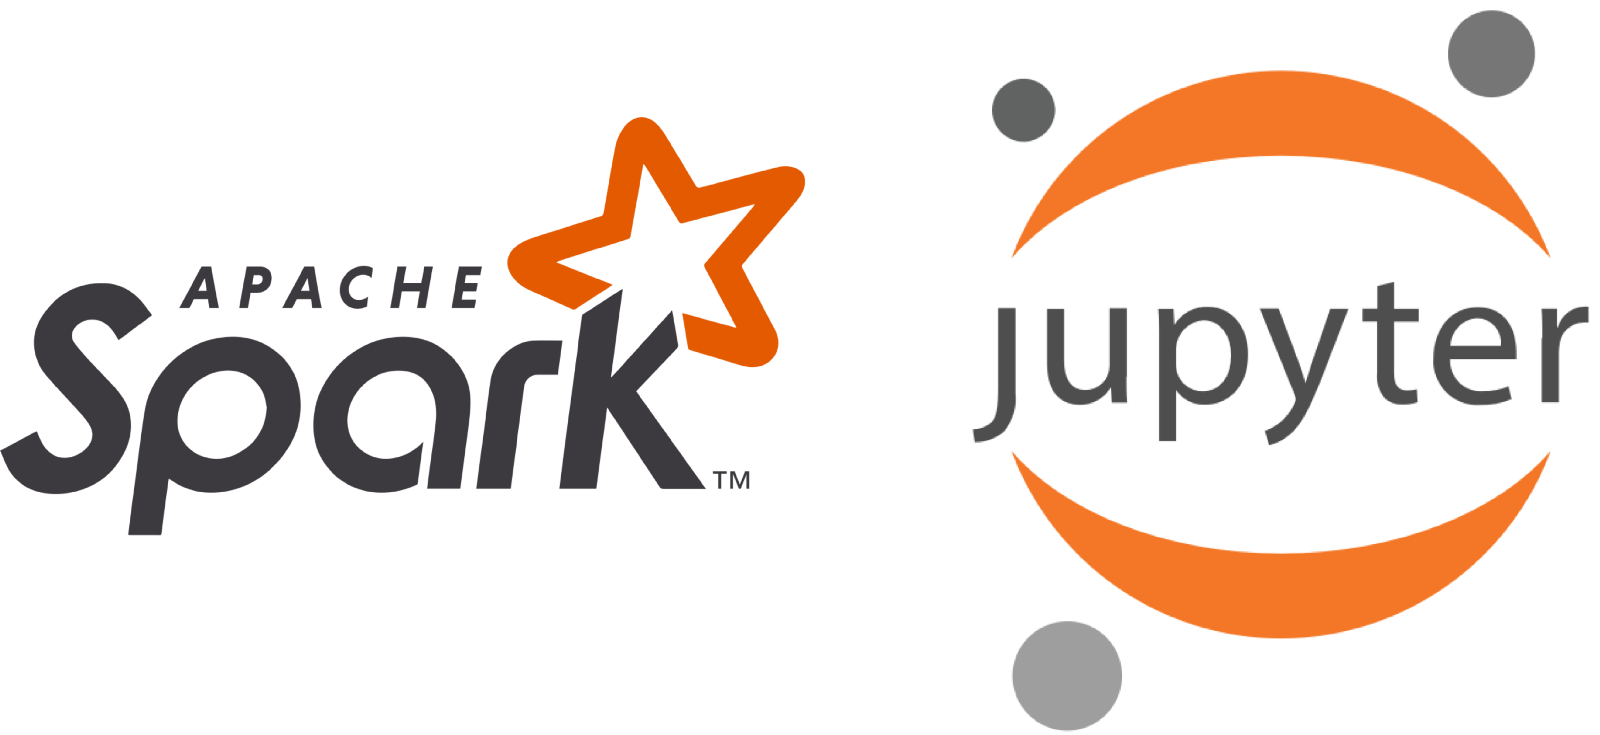

# How to find a needle in a very, very large haystack using Apache Spark

## Jupyter notebooks
First things first: this is a Jupyter notebook!

* Each box is a cell that can contain either Python code (or other languages), or Markdown.
* To execute a code cell, press Shift + Enter.

In [1]:
# Example: press Shift + Enter in this box.

print("This cell was executed.")

This cell was executed.


You can enter _command mode_ by pressing Escape, and enter _edit mode_ by pressing Return.

This next cell will make things a bit prettier for the rest of the workshop:

In [18]:
%run init.py

# Import PySpark packages
from pyspark.sql import *
import pyspark.sql.functions as F

# Use "col" as a shortcut for F.column
F.col = F.column

# Use "percentile_approx" as a shortcut for expr('percentile_approx()')
def percentile_approx(column, perc):
    return F.expr("percentile_approx({}, {})".format(column, perc))

F.percentile_approx = percentile_approx

# Set up some plotting parameters
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
sns.set_context("notebook", font_scale=2)


# Let's start using some Spark!

## Amazon reviews for Electronics

In the folder you were sent, there are two data files in JSON format. You can check their names by invoking a shell command from Jupyter (just prepend `!` to the cell to run a shell command):

In [3]:
! ls -lh *.json

-rw-r--r-- 1 root root 1.4G Sep 21 22:38 reviews.json


We see there's a JSON file that's approximately 1.4 G. Not quite big data, but no slouch either :)


We can view the first few records using jq:

In [4]:
! head reviews.json | jq

{
  "asin": "B001I45T9O",
  "date": "2009-03-12 19:00:00",
  "fraction_helpful": 1,
  "overall": 5,
  "reviewText": "I did extensive web research before purchasing this laptop; while these seem a bit less common than their MSI and Asus brethren, the reviews were uniformly positive. The features that I was most interested in were long battery life, great keyboard, built-in bluetooth (I wanted to use my Microsoft wireless presenter mouse), and Windows 7 compatibility. After a few weeks of use, I am completely satisfied with the choice. It is a solid feeling little box, and the keyboard is better than most full-size laptops. The Windows 7 beta works great on it - battery life only a little less than with XP and performance at least as good as with XP. The display quality is excellent. I was initially concerned that the touch pad is rather small, but in practice that really doesn't seem to be a problem - I have no problem using it, although in general due to habit I prefer to use an extern

To load in a dataset, you use one of the `spark.read.{format}("path")` methods. In this case, the format is *JSON*, so we'll use `spark.read.json(path)`:

In [5]:
reviews = spark.read.json("reviews.json")
reviews.cache()

DataFrame[asin: string, date: string, fraction_helpful: double, overall: double, reviewText: string, reviewerID: string, reviewerName: string, summary: string, total_rating: bigint]

The `reviews` object is a Spark DataFrame. For this dataset, each row is a review.

You can view the contents of the first few rows by using the `display` function:

In [7]:
display(reviews)

,asin,date,fraction_helpful,overall,reviewText,reviewerID,reviewerName,summary,total_rating
0,B001I45T9O,2009-03-12 19:00:00,1.000000,5.0,I did extensive web research before purchasing this laptop; while these seem a bit less common t...,A2B82QHMXGBYFB,Amazon Customer,great all-round laptop,3
1,B001I45T9O,2009-02-01 18:00:00,0.857143,5.0,"After my laptop suddenly died recently, I needed a new portable computer, and fast. I did some ...",A1RTIPSBPL6L0D,Amazon Customer,The best Netbook out there right now!!,7
2,B001I45T9O,2008-12-13 18:00:00,1.000000,5.0,"I purchased the NC10 from amazon after doing quite a bit of research, I went to several stores ...",AK07I3266VXWY,"Amazon Customer ""Soutthpaw""","Hands Down, Best Netbook!",10
3,B001I45T9O,2009-04-16 19:00:00,0.900000,4.0,I purchased the white NC10 from Ritz Camera (an Amazon seller) about a week ago and received it ...,A2XL01EGU7MRGF,BE Babe,The first thing you should do when you receive this netbook -- run a screen test,10
4,B001I45T9O,2009-07-24 19:00:00,1.000000,4.0,"After carrying around a brick in my briefcase for years, I decided I needed to get a sub or netb...",A2M4NHKCBDV4OD,"B. V. Dam ""California Candyman""","Great Netbook, nice stlying, lightweight....small buts",2
5,B001I45T9O,2009-02-03 18:00:00,0.833333,5.0,Pros:1.) 6-8 hours battery life2.) 30 second boot up time3.) the best keyboard4.) LCD with backl...,A10BXAXOXN8H7A,Chad Herrella,The best netbook as of now!,6
6,B001I45T9O,2009-01-20 18:00:00,0.909091,4.0,This is an update to the previous review. After several days of loading new drivers and updates ...,A24957HBA987VN,"C. Moore ""The Authorguy""",Stuff you should know,11
7,B001I45T9O,2009-02-28 18:00:00,1.000000,5.0,After a few months of reading reviews about of all of the positives and negatives that come with...,AENBUGC3GZN78,"C. Rash ""Bandicoot""",Good things come in small packages,3
8,B001I45T9O,2008-11-21 18:00:00,0.976190,4.0,The Samsung NC10 is clearly the best netbook on the market right now. As a previous owner of the...,A1ALP9R0BD9XBB,"Daniel ""shinbo""",Bottom line best netbook out of them all.,42
9,B001I45T9O,2009-01-26 18:00:00,0.904762,5.0,"I was all set to get the Asus eeePC1000HA netbook until I heard about this new Samsung, spent a ...",AT6CZDCP4TRGA,Eduarrdo Nietzsche,"""Less"" really IS ""more!"" and all the buzz turned out to be TRUE, for once!",21


...and you can see the number of rows in the dataframe calling the `.count()` method:

In [8]:
print("There are ", reviews.count(), " reviews in this dataset.")

There are  1689188  reviews in this dataset.


The columns in this file are:

* `asin`: an Amazon product identifier
* `date`: the date of the review
* `overall`: the user's review
* `summary`: the title of the review
* `reviewText`: the text of the review
* `reviewerID`: the ID of the user
* `reviewerName`: the name of the reviewer
* `total_rating`: how many people rated the review
* `fraction_helpful`: the fraction of people who found the review helpful

## Diversion: the Spark Web UI
If you navigate to [http://localhost:4040](http://localhost:4040), you will see the Spark Web UI. The Web UI works like a "Task Manager" for Spark -- you can see currently ongoing jobs, how those jobs are broken up into tasks, and _kill_ current tasks.

<hr>

# Heuristics for identifying fake reviews
Based on this data, how could we spot a fake reviewer and a product that's been boosted by fake reviews?

## Some ideas

Maybe a fake reviewer could be identified by looking at some simple metrics...
* The reviewer posts way more reviews than the typical user
* Most of their reviews are positive
* Most of their reviews are sent very quickly
* Most of their reviews are low quality (other users don't find them very helpful)
* Most of their reviews texts and titles are shorter than the average
* A product that's being boosted by their merchant has been reviewed by a lot of fake reviewers

## Aggregations: let's look at the distribution of reviews (1-5 stars)

In [9]:
# Take the reviews, group them by the number of star ("overall"), and
# count the number of reviews in each group.
#

reviews_by_stars = reviews \
    .groupBy("overall") \
    .agg(F.count("*").alias("count")) \
    .orderBy("overall")

display(reviews_by_stars)

,overall,count
0,1.0,108725
1,2.0,82139
2,3.0,142257
3,4.0,347041
4,5.0,1009026


Let's dissect that call:

* We're calling several methods on the dataframe in a row. This is called a **pipeline**.
* I put each method call on a separate line to make it easier to see the flow.

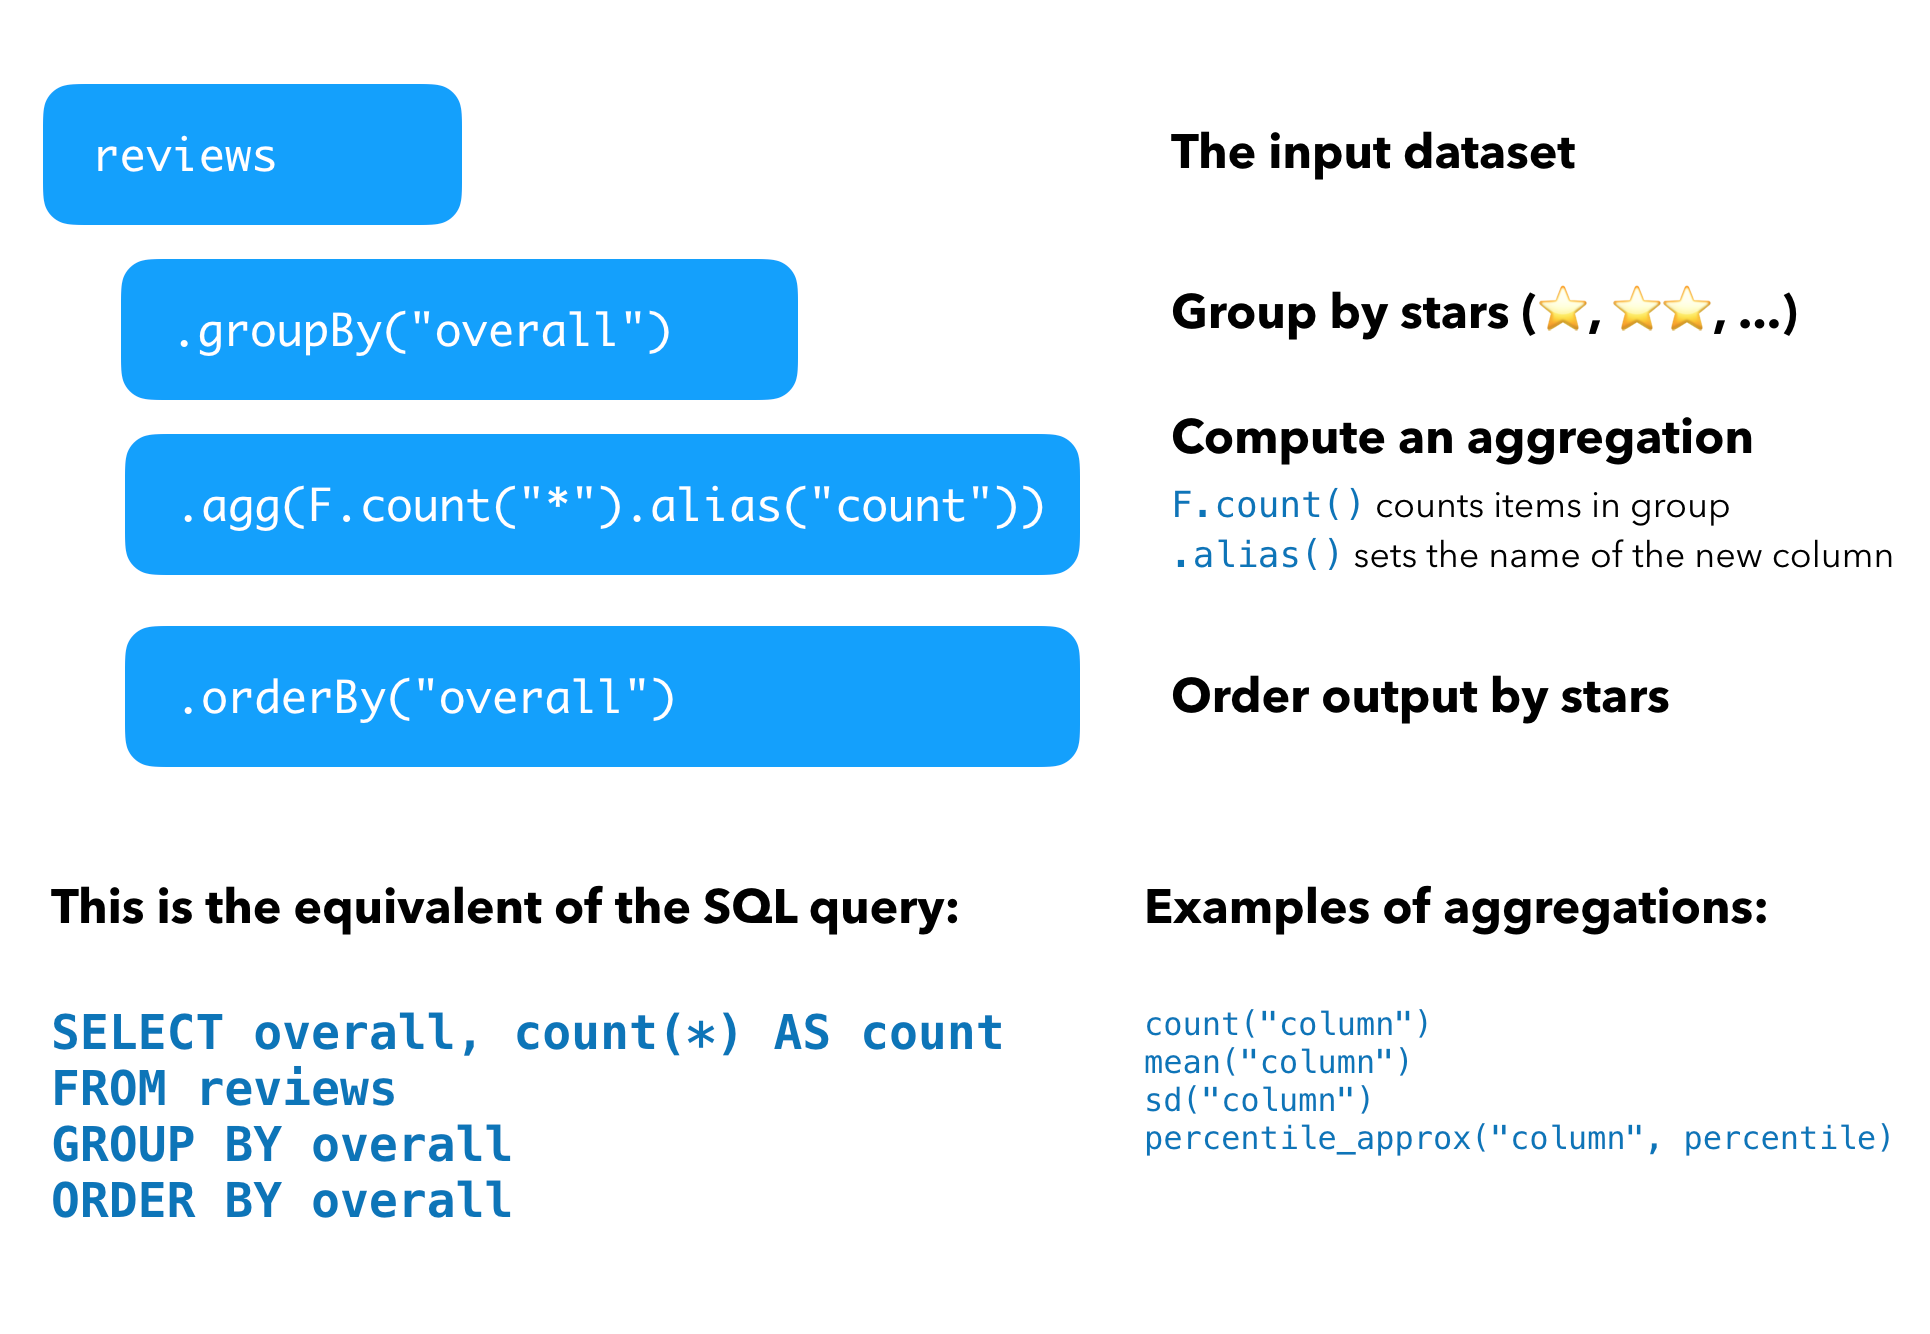

Let's visualize that distribution:

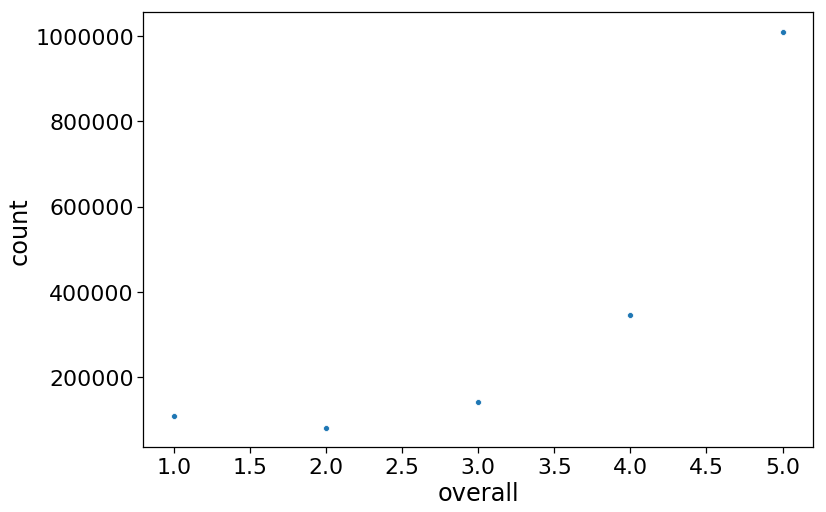

In [17]:
reviews_by_stars.plot(x="overall", y="count")

### How many reviews do users leave, typically?

Intuition: some users might leave way more reviews than others, especially if they have a financial incentive to do so.

In [15]:
# Group by reviewer ID and count reviews.
# Returns a table of number of reviews left by each user
count_reviews = reviews \
    .groupBy("reviewerID") \
    .agg(
        F.count("*").alias("count_reviews"),
        F.datediff(F.max("date"), F.min("date")).alias("activity_time_span"),
        F.mean("overall").alias("overall")
    )

# The withColumn(columnName, columnExpression) method adds a new column
count_reviews = count_reviews.withColumn("reviews_per_day", F.expr("count_reviews / activity_time_span"))

display(count_reviews)

,reviewerID,count_reviews,activity_time_span,overall,reviews_per_day
0,A06983862QXQ79V198HHI,5,369,4.400000,0.013550
1,A10123371OF8W0NAB6A1Q,10,48,3.900000,0.208333
2,A10C5589JX44C7,5,438,3.400000,0.011416
3,A10KHX41ONY4U1,5,377,5.000000,0.013263
4,A10M0GF5ZFODYU,32,1280,4.468750,0.025000
5,A10T7OCXQFU89X,7,751,3.571429,0.009321
6,A10T8DZNS4DMYL,5,9,4.000000,0.555556
7,A117LEKZFV4ZHC,8,1238,2.750000,0.006462
8,A11F5CJ7LAR24U,6,685,4.833333,0.008759
9,A11JEFCFYWYV4W,8,364,4.750000,0.021978


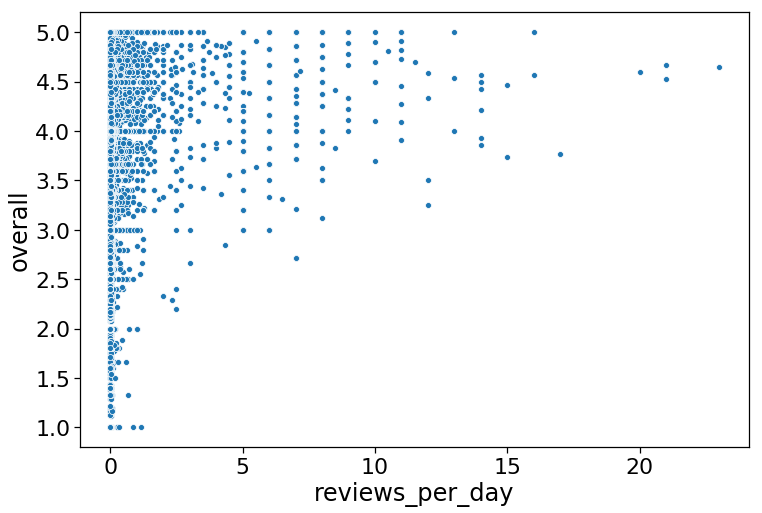

In [31]:
count_reviews_per_day.plot(x="reviews_per_day", y="overall")

In [32]:
# Now, let's see how many users have a given number of reviews.
# We group by count_reviews, then count the number of users in each bucket.

count_users = count_reviews \
    .groupBy("count_reviews") \
    .agg(
        F.count("*").alias("count_users")
    )

display(count_users)

,count_reviews,count_users
0,29,307
1,26,436
2,65,23
3,367,1
4,19,1196
5,54,45
6,113,5
7,112,2
8,241,2
9,22,731


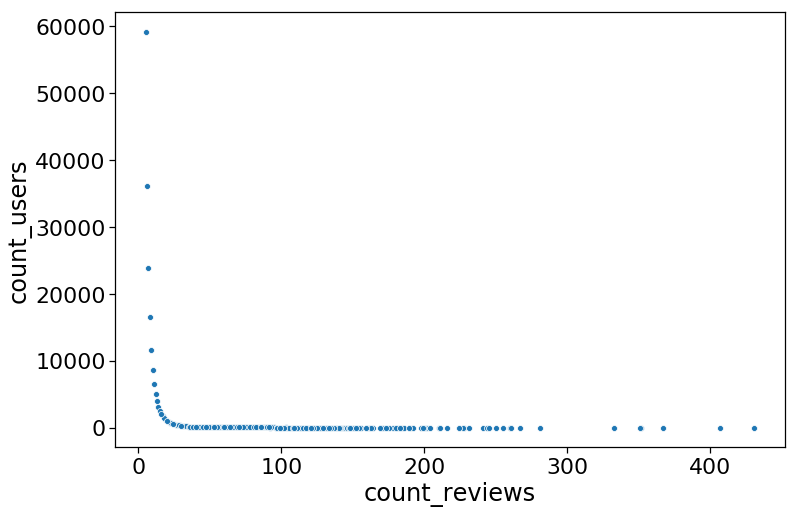

In [33]:
count_users.plot(x="count_reviews", y="count_users")

The *vast* majority of users leaves fewer than 50 reviews. How do we quantify this more precisely?

The function `percentile_approx` is an aggregation returns an approximate percentile. 

In [34]:
# Compute 90th, 95th, and 99th percentile (X percentile: X% of users left this many reviews or fewer)

perc = count_reviews.agg(F.percentile_approx("count_reviews", 0.9).alias("90"),
                         F.percentile_approx("count_reviews", 0.95).alias("95"),
                         F.percentile_approx("count_reviews", 0.99).alias("99"))

display(perc)

,90,95,99
0,14,19,39


Let's find what those reviewers look like! 

We take `count_reviews` (a table of user IDs and review counts) and join it with the `review` table, using `reviewerID` as the joining column.

In [35]:
reviews_with_counts = reviews.join(count_reviews, "reviewerID")

# Check it out! Now there's a "count_reviews" column.
display(reviews_with_counts)

,reviewerID,asin,date,fraction_helpful,overall,reviewText,reviewerName,summary,total_rating,count_reviews,activity_time_span,overall,reviews_per_day
0,A2B82QHMXGBYFB,B001I45T9O,2009-03-12 19:00:00,1.000000,5.0,I did extensive web research before purchasing this laptop; while these seem a bit less common t...,Amazon Customer,great all-round laptop,3,10,1948,4.400000,0.005133
1,A1RTIPSBPL6L0D,B001I45T9O,2009-02-01 18:00:00,0.857143,5.0,"After my laptop suddenly died recently, I needed a new portable computer, and fast. I did some ...",Amazon Customer,The best Netbook out there right now!!,7,6,2466,4.000000,0.002433
2,AK07I3266VXWY,B001I45T9O,2008-12-13 18:00:00,1.000000,5.0,"I purchased the NC10 from amazon after doing quite a bit of research, I went to several stores ...","Amazon Customer ""Soutthpaw""","Hands Down, Best Netbook!",10,8,1829,4.125000,0.004374
3,A2XL01EGU7MRGF,B001I45T9O,2009-04-16 19:00:00,0.900000,4.0,I purchased the white NC10 from Ritz Camera (an Amazon seller) about a week ago and received it ...,BE Babe,The first thing you should do when you receive this netbook -- run a screen test,10,7,1040,4.571429,0.006731
4,A2M4NHKCBDV4OD,B001I45T9O,2009-07-24 19:00:00,1.000000,4.0,"After carrying around a brick in my briefcase for years, I decided I needed to get a sub or netb...","B. V. Dam ""California Candyman""","Great Netbook, nice stlying, lightweight....small buts",2,9,4220,4.000000,0.002133
5,A10BXAXOXN8H7A,B001I45T9O,2009-02-03 18:00:00,0.833333,5.0,Pros:1.) 6-8 hours battery life2.) 30 second boot up time3.) the best keyboard4.) LCD with backl...,Chad Herrella,The best netbook as of now!,6,5,1362,5.000000,0.003671
6,A24957HBA987VN,B001I45T9O,2009-01-20 18:00:00,0.909091,4.0,This is an update to the previous review. After several days of loading new drivers and updates ...,"C. Moore ""The Authorguy""",Stuff you should know,11,21,3444,4.142857,0.006098
7,AENBUGC3GZN78,B001I45T9O,2009-02-28 18:00:00,1.000000,5.0,After a few months of reading reviews about of all of the positives and negatives that come with...,"C. Rash ""Bandicoot""",Good things come in small packages,3,10,1350,4.900000,0.007407
8,A1ALP9R0BD9XBB,B001I45T9O,2008-11-21 18:00:00,0.976190,4.0,The Samsung NC10 is clearly the best netbook on the market right now. As a previous owner of the...,"Daniel ""shinbo""",Bottom line best netbook out of them all.,42,7,1484,4.000000,0.004717
9,AT6CZDCP4TRGA,B001I45T9O,2009-01-26 18:00:00,0.904762,5.0,"I was all set to get the Asus eeePC1000HA netbook until I heard about this new Samsung, spent a ...",Eduarrdo Nietzsche,"""Less"" really IS ""more!"" and all the buzz turned out to be TRUE, for once!",21,145,4233,3.737931,0.034255


Let's look at that 1% tail of users with more than 39 reviews, and more than 1 review per day.

In [51]:
frequent_reviewers = reviews_with_counts \
    .filter("count_reviews > 19 and reviews_per_day > 1") \
    .orderBy("reviewerID")
    
display(frequent_reviewers, n=25)

,reviewerID,asin,date,fraction_helpful,overall,reviewText,reviewerName,summary,total_rating,count_reviews,activity_time_span,overall,reviews_per_day
0,A123E03CA53CHJ,B006TT91TW,2014-07-08 19:00:00,1.000000,5.0,"Great hub, lots of space and easy to tell when there is activity",Ben,Five Stars,1,22,2,5.0,11.000000
1,A123E03CA53CHJ,B003YIFHJY,2014-07-07 19:00:00,0.000000,5.0,"Excellent, everything you need",Ben,Five Stars,0,22,2,5.0,11.000000
2,A123E03CA53CHJ,B008OHNZI0,2014-07-09 19:00:00,0.000000,5.0,Good screen,Ben,Five Stars,0,22,2,5.0,11.000000
3,A123E03CA53CHJ,B00CP1129K,2014-07-07 19:00:00,0.000000,5.0,"Nice clean cable, fit what I needed it to",Ben,Five Stars,0,22,2,5.0,11.000000
4,A123E03CA53CHJ,B000067SOH,2014-07-08 19:00:00,0.000000,5.0,Good adaptor,Ben,Five Stars,0,22,2,5.0,11.000000
5,A123E03CA53CHJ,B0002MQGOK,2014-07-09 19:00:00,0.000000,5.0,Nice cable,Ben,Five Stars,0,22,2,5.0,11.000000
6,A123E03CA53CHJ,B0082YEH8M,2014-07-09 19:00:00,0.000000,5.0,"Good case, though no magnet to hold tri-flap in triangle like on the case for my nexus 7",Ben,Five Stars,0,22,2,5.0,11.000000
7,A123E03CA53CHJ,B007SM7O2U,2014-07-08 19:00:00,0.000000,5.0,"Perfect, right on time",Ben,Five Stars,0,22,2,5.0,11.000000
8,A123E03CA53CHJ,B00FMIYEKW,2014-07-08 19:00:00,1.000000,5.0,Awesome little radio for a great price,Ben,Five Stars,1,22,2,5.0,11.000000
9,A123E03CA53CHJ,B00CP0I474,2014-07-08 19:00:00,0.000000,5.0,Very nice to have for your radio,Ben,Five Stars,0,22,2,5.0,11.000000


<br>
<div style="text-align:center; font-size: 5rem;">🧐 HMMM</div>

"Ben" left 22 reviews in three days, all five stars, all with the same title. How many other users behave like that?